## CAM Heatmap a VGG Visualization

In this notebook we will be using an attention analisys to visualize parts of the image!

This is a pytorch implementation of the paper _Learning Deep Features for Discriminative Localization_ by
_Bolei Zhou, Aditya Khosla, Agata Lapedriza, Aude Oliva and Antonio Torralba_
http://openaccess.thecvf.com/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

ref: https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/grad-cam-introduction-d0e48eb64adb

In [1]:
#! wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

In [2]:
import cv2
import torchvision.models as models
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

# Get outputs
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())
    
filepath = 'istockphoto-tiger.jpg'
testImg = np.array(Image.open(filepath))/256

In [3]:
# Load model
model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# Pass tensors for predition
imgTensor = torch.unsqueeze(torch.tensor(testImg).permute(2,0,1).float(),0)
from torchsummary import summary
summary(model, imgTensor)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 12, 19]         --
|    └─Conv2d: 2-1                       [-1, 64, 406, 612]        1,792
|    └─ReLU: 2-2                         [-1, 64, 406, 612]        --
|    └─Conv2d: 2-3                       [-1, 64, 406, 612]        36,928
|    └─ReLU: 2-4                         [-1, 64, 406, 612]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 203, 306]        --
|    └─Conv2d: 2-6                       [-1, 128, 203, 306]       73,856
|    └─ReLU: 2-7                         [-1, 128, 203, 306]       --
|    └─Conv2d: 2-8                       [-1, 128, 203, 306]       147,584
|    └─ReLU: 2-9                         [-1, 128, 203, 306]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 101, 153]       --
|    └─Conv2d: 2-11                      [-1, 256, 101, 153]       295,168
|    └─ReLU: 2-12                        [-1, 256, 101, 153]    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 12, 19]         --
|    └─Conv2d: 2-1                       [-1, 64, 406, 612]        1,792
|    └─ReLU: 2-2                         [-1, 64, 406, 612]        --
|    └─Conv2d: 2-3                       [-1, 64, 406, 612]        36,928
|    └─ReLU: 2-4                         [-1, 64, 406, 612]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 203, 306]        --
|    └─Conv2d: 2-6                       [-1, 128, 203, 306]       73,856
|    └─ReLU: 2-7                         [-1, 128, 203, 306]       --
|    └─Conv2d: 2-8                       [-1, 128, 203, 306]       147,584
|    └─ReLU: 2-9                         [-1, 128, 203, 306]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 101, 153]       --
|    └─Conv2d: 2-11                      [-1, 256, 101, 153]       295,168
|    └─ReLU: 2-12                        [-1, 256, 101, 153]    

Text(0.5, 1.0, 'tiger, Panthera tigris')

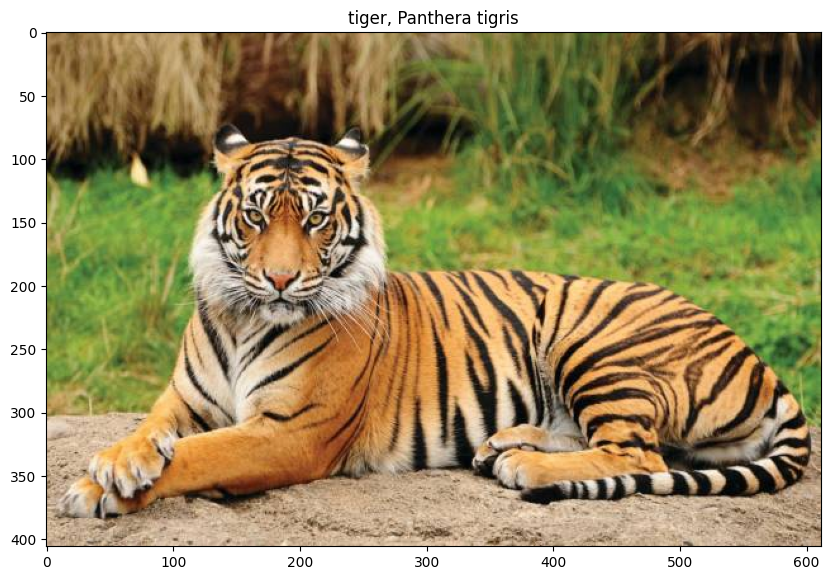

In [5]:
imgTensor.requires_grad = True #為了取得這個tensor的梯度
outImg = model(imgTensor)
test_pred = idx2label[torch.argmax(outImg).item()]

plt.figure(figsize=(10,10))
plt.imshow(testImg)
plt.title(test_pred)

## Ok the network works!

Now we need to calculate the gradients for the class multiply them by the last activation layer..
We need to get the last convolutional layer of the network, wich is located at: features[29]


## Creating a new class based of VGG

We create this class so we can _"chop off"_ a peice of the network, this is required so we can calculate the gradient and get the network state at the last convolution layer[](http://)..

In [6]:
class CamVGG(nn.Module):
    def __init__(self):
        super(CamVGG, self).__init__()
        self.vgg = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
        self.until_last_conv = self.vgg.features[:30]
        # Recreate MaxPool Layer
        self.max_pool = self.vgg.features[30]
        # Get VGG Adaptive Pool
        self.adaptive_pool = self.vgg.avgpool
        # Get VGG Classifier
        self.classifier = self.vgg.classifier
        # Gradients
        self.gradients = None

    def hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.until_last_conv(x)
        h = x.register_hook(self.hook)
        x = self.max_pool(x)
        x = self.adaptive_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x


Let's do a predition to make sure our new class behaves as expected...

/var/folders/1_/g97gwqs50f34bdww3vd383c40000gn/T/ipykernel_8815/1790530059.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


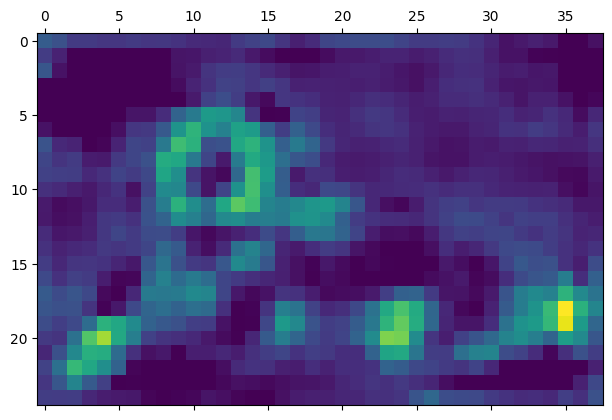

In [7]:
CamModel = CamVGG()
pred = CamModel(imgTensor)
pred_idx = torch.argmax(pred).item()
# Propagate predicted class
pred[:, pred_idx].backward()
# Get the gradient
gradients = CamModel.gradients
# Take the mean on given dimentions...
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
# Multiply calculated gradients by last convolution
activations = CamModel.until_last_conv(imgTensor).detach()
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# Calculate mean for all convolutions to create heatmap
heatmap = torch.mean(activations, dim=1).squeeze()
# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
# Plot Heatmap
plt.matshow(heatmap.squeeze())


/var/folders/1_/g97gwqs50f34bdww3vd383c40000gn/T/ipykernel_8815/2113242251.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  heatmap1 = np.array(heatmap)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.49609375].


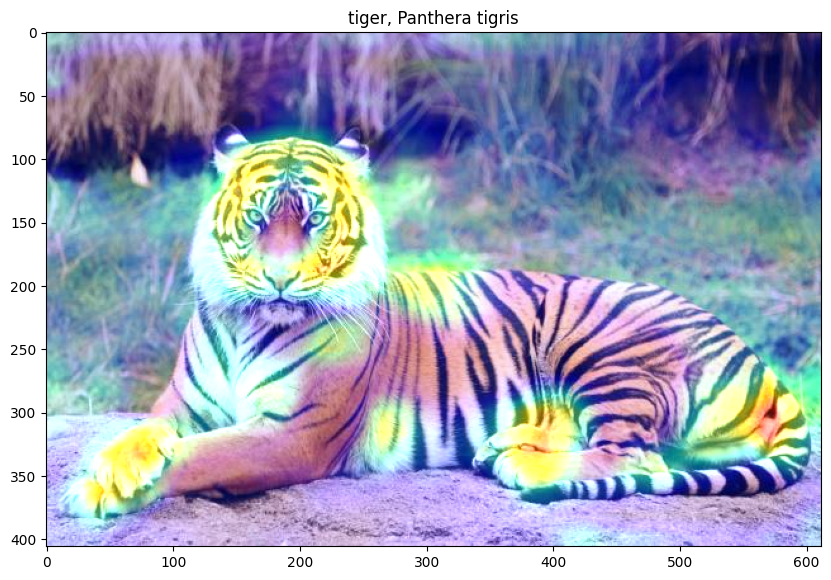

In [9]:
# Get image as BGR
img = testImg[...,::-1]*255
# Resize Heatmap and apply color map
heatmap1 = np.array(heatmap)
heatmap1 = cv2.resize(heatmap1, (img.shape[1], img.shape[0]))
heatmap1 = np.uint8(255 * heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
# Superpose image
superimposed_img = heatmap1 * 0.5 + img
superimposed_img = superimposed_img[...,::-1]

plt.figure(figsize=(10,10))
plt.imshow(superimposed_img/255)
plt.title(test_pred)
plt.show()